### Importing libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

### Loading the dataset 

In [3]:
df = pd.read_csv('stack-overflow-data.csv')

In [4]:
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    40000 non-null  object
 1   tags    40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [6]:
df.tags.value_counts()

c#               2000
java             2000
c                2000
python           2000
objective-c      2000
html             2000
android          2000
css              2000
ios              2000
javascript       2000
ruby-on-rails    2000
iphone           2000
jquery           2000
mysql            2000
.net             2000
angularjs        2000
c++              2000
sql              2000
asp.net          2000
php              2000
Name: tags, dtype: int64

### Plotting the tags count 

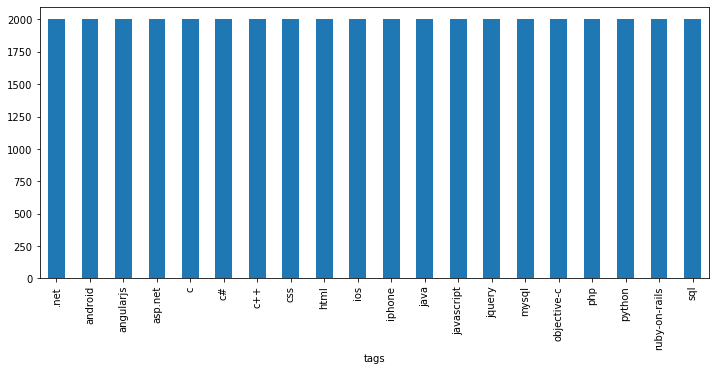

In [7]:
fig = plt.figure(figsize=(12,5))
df.groupby('tags').post.count().plot.bar(ylim=0)
plt.show();

In [8]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print('Post:',example[0])
        print('Tag:', example[1])

In [9]:
print_plot(15)

Post: connection in .net  i got     <blockquote>    <code>system.data.datarow.datarow(system.data.datarowbuilder)</code> is inaccessible due to its protection   level.  </blockquote>   while connecting to sql-server. what does it mean
Tag: .net


### Plotting Frequency Distribution of top tokens before preprocessing

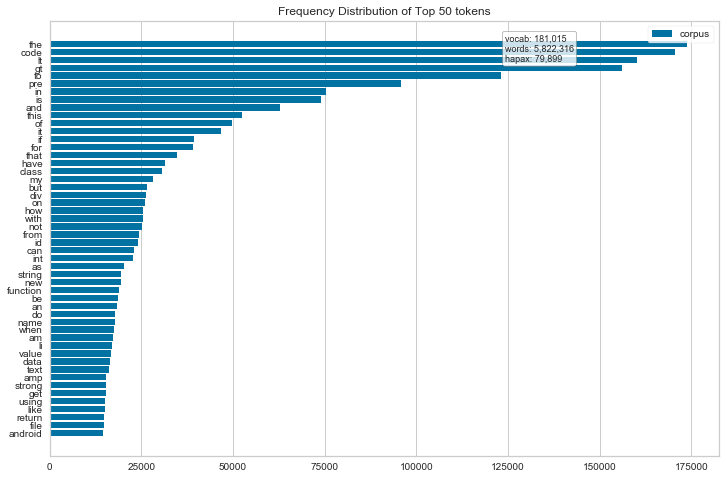

In [10]:
from sklearn.feature_extraction.text import  CountVectorizer
from yellowbrick.text import FreqDistVisualizer
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['post'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

### Pre-processing post 

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') #replace symbols with space
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
    
df['post'] = df['post'].apply(clean_text)

In [12]:
print_plot(15)

Post: connection net got systemdatadatarowdatarow systemdatadatarowbuilder inaccessible due protection level connecting sqlserver mean
Tag: .net


### Plotting Frequency Distribution of top tokens after preprocessing

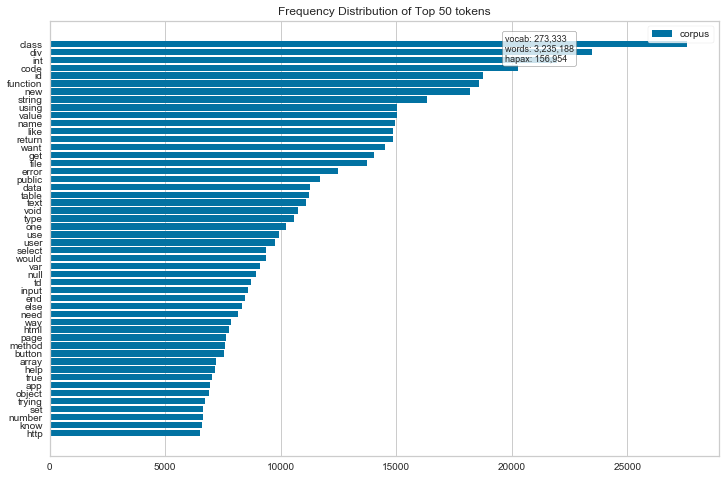

In [13]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['post'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## Vectorize the post text 

In [14]:
#which is the size of vocabulary
MAX_NB_WORDS = 5000 
# Max number of words in each post.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer =Tokenizer(num_words=MAX_NB_WORDS, char_level=False,  lower=True)
tokenizer.fit_on_texts(df['post'].values) 

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 247056 unique tokens.


###  Truncate and pad the input sequences

Next, we need to truncate and pad the input sequences so that they are all the same length for modeling. The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras.

In [15]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (40000, 250)


###  Encoding tags (labels)

In [16]:
from keras import utils

encoder = LabelEncoder()
encoder.fit(df['tags'])
Y = encoder.transform(df['tags'])

num_classes = np.max(Y) + 1
Y = utils.to_categorical(Y, num_classes)

print('Shape of label tensor:', Y.shape)

Shape of label tensor: (40000, 20)


### Train Test Split 

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print('Train_data : ',X_train.shape)
print('Train_label : ',Y_train.shape)
print('Test_data: ',X_test.shape)
print('Test_label: ',Y_test.shape)

Train_data :  (36000, 250)
Train_label :  (36000, 20)
Test_data:  (4000, 250)
Test_label:  (4000, 20)


### Network Modeling 

The first layer is the Embedded layer that uses 100 length vectors to represent each word. The next layer is the LSTM layer with 100 memory units (smart neurons). Finally, because this is a classification problem we use a Dense output layer with 20 labels and a softmax activation function to make predictions for the 20 classes.

In [18]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          500000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
Total params: 582,420
Trainable params: 582,420
Non-trainable params: 0
_________________________________________________________________
None


### Training 

In [19]:
epochs = 7
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 32400 samples, validate on 3600 samples
Epoch 1/7
32400/32400 [==============================] - 168s 5ms/step - loss: 2.1256 - accuracy: 0.2690 - val_loss: 1.7654 - val_accuracy: 0.3958
Epoch 2/7
32400/32400 [==============================] - 169s 5ms/step - loss: 1.4125 - accuracy: 0.4963 - val_loss: 1.1077 - val_accuracy: 0.6028
Epoch 3/7
32400/32400 [==============================] - 169s 5ms/step - loss: 1.0699 - accuracy: 0.6212 - val_loss: 0.9028 - val_accuracy: 0.6922
Epoch 4/7
32400/32400 [==============================] - 165s 5ms/step - loss: 0.8139 - accuracy: 0.7222 - val_loss: 0.7951 - val_accuracy: 0.7481
Epoch 5/7
32400/32400 [==============================] - 166s 5ms/step - loss: 0.6805 - accuracy: 0.7798 - val_loss: 0.6897 - val_accuracy: 0.7836
Epoch 6/7
32400/32400 [==============================] - 165s 5ms/step - loss: 0.5863 - accuracy: 0.8146 - val_loss: 0.6513 - val_accuracy: 0.7922
Epoch 7/7
32400/32400 [==============================] - 168s 5ms/st

### Test Set Accuracy 

In [20]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4000/4000 [==============================] - 6s 1ms/step
Test set
  Loss: 0.661
  Accuracy: 0.805


### Train and Test Loss  

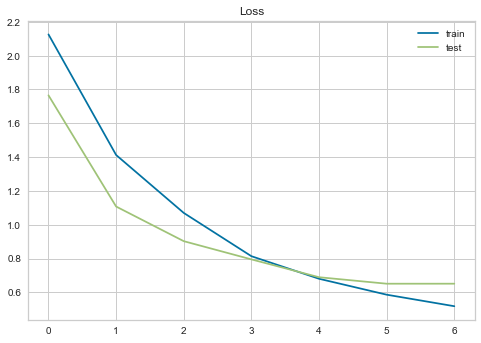

In [21]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

###  Train and Test Accuracy

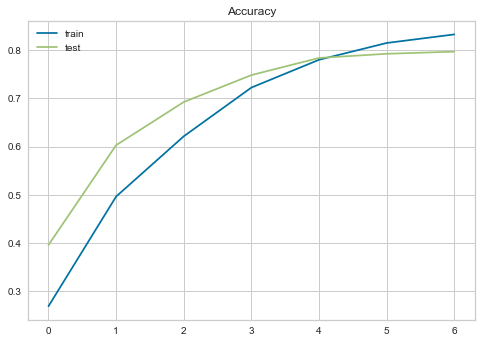

In [22]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [23]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

Y_pred = model.predict(X_test)
#print(Y_pred)

y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)


target=['.net(0)','android(1)','angularJS(2)','asp.net(3)',
        'c(4)','c#(5)','c++(6)','css(7)','html(8)','ios(9)',
        'iphone(10)','java(11)','javascript(12)','jquery(13)',
        'mysql(14)','objective_c(15)','php(16)','python(17)',
        'ruby_on_rails(18)','sql(19)']

In [24]:
print(classification_report(np.argmax(Y_test, axis=1), y_pred, target_names = target))
cnf_matrix=(confusion_matrix(np.argmax(Y_test, axis=1), y_pred))

                   precision    recall  f1-score   support

          .net(0)       0.79      0.73      0.76       214
       android(1)       0.96      0.89      0.92       197
     angularJS(2)       0.98      0.93      0.95       189
       asp.net(3)       0.78      0.77      0.77       198
             c(4)       0.87      0.80      0.83       192
            c#(5)       0.66      0.69      0.68       195
           c++(6)       0.75      0.81      0.78       204
           css(7)       0.88      0.85      0.86       204
          html(8)       0.64      0.72      0.67       202
           ios(9)       0.64      0.74      0.69       207
       iphone(10)       0.70      0.67      0.69       196
         java(11)       0.85      0.86      0.86       214
   javascript(12)       0.73      0.80      0.76       177
       jquery(13)       0.87      0.83      0.85       184
        mysql(14)       0.89      0.76      0.82       177
  objective_c(15)       0.77      0.65      0.71       

In [25]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


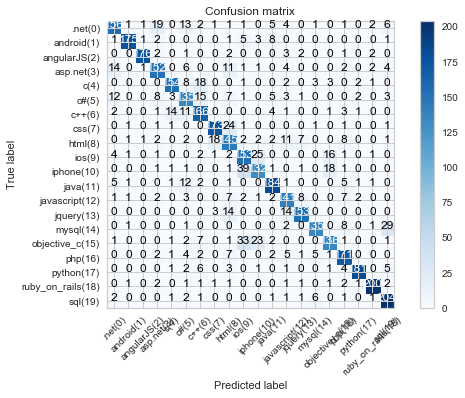

In [26]:
import itertools
plot_confusion_matrix(cnf_matrix, classes = target, title ='Confusion matrix')

In [27]:
from keras.models import load_model
model.save('text.h5')
print('model saved ')

model saved 


In [28]:
#from keras.models import load_model

#MODEL_PATH = 'text.h5'
#model = load_model(MODEL_PATH)
#model._make_predict_function()  

# Using Machine learning approach

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

After text cleaning and removing stop words, we have only over 3 million

In [30]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424297

### Train and Test split 

In [31]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Naive Bayes Classifier for Multinomial Models 

In [36]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

#%%time

y_pred = nb.predict(X_test)

nb_acc = accuracy_score(y_pred, y_test)
#print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=target))

                   precision    recall  f1-score   support

          .net(0)       0.63      0.65      0.64       613
       android(1)       0.94      0.86      0.90       620
     angularJS(2)       0.87      0.92      0.90       587
       asp.net(3)       0.70      0.77      0.73       586
             c(4)       0.73      0.87      0.79       599
            c#(5)       0.72      0.51      0.60       589
           c++(6)       0.77      0.74      0.75       594
           css(7)       0.69      0.89      0.78       610
          html(8)       0.63      0.59      0.61       617
           ios(9)       0.57      0.65      0.60       587
       iphone(10)       0.70      0.50      0.59       611
         java(11)       0.79      0.78      0.79       594
   javascript(12)       0.84      0.59      0.69       619
       jquery(13)       0.66      0.84      0.74       574
        mysql(14)       0.64      0.83      0.72       584
  objective_c(15)       0.66      0.64      0.65       

## SGD Classifier 

In [37]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

#%%time

y_pred = sgd.predict(X_test)

sgd_acc = accuracy_score(y_pred, y_test)
#print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=target))

                   precision    recall  f1-score   support

          .net(0)       0.73      0.67      0.70       613
       android(1)       0.84      0.94      0.89       620
     angularJS(2)       0.88      0.95      0.92       587
       asp.net(3)       0.81      0.80      0.80       586
             c(4)       0.73      0.89      0.80       599
            c#(5)       0.77      0.39      0.52       589
           c++(6)       0.81      0.69      0.74       594
           css(7)       0.71      0.95      0.81       610
          html(8)       0.83      0.57      0.67       617
           ios(9)       0.72      0.58      0.64       587
       iphone(10)       0.71      0.65      0.68       611
         java(11)       0.79      0.88      0.83       594
   javascript(12)       0.77      0.79      0.78       619
       jquery(13)       0.84      0.86      0.85       574
        mysql(14)       0.82      0.81      0.81       584
  objective_c(15)       0.70      0.68      0.69       

##  Logistic Regression

In [38]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

#%%time

y_pred = logreg.predict(X_test)

logreg_acc = accuracy_score(y_pred, y_test)

#print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=target))

                   precision    recall  f1-score   support

          .net(0)       0.68      0.64      0.66       613
       android(1)       0.92      0.90      0.91       620
     angularJS(2)       0.96      0.95      0.96       587
       asp.net(3)       0.75      0.77      0.76       586
             c(4)       0.79      0.81      0.80       599
            c#(5)       0.61      0.58      0.59       589
           c++(6)       0.78      0.74      0.76       594
           css(7)       0.84      0.86      0.85       610
          html(8)       0.70      0.72      0.71       617
           ios(9)       0.61      0.60      0.61       587
       iphone(10)       0.65      0.64      0.65       611
         java(11)       0.83      0.82      0.82       594
   javascript(12)       0.77      0.78      0.77       619
       jquery(13)       0.86      0.84      0.85       574
        mysql(14)       0.82      0.84      0.83       584
  objective_c(15)       0.66      0.67      0.66       

## All classifier accuracy score 

In [42]:
print('Naive Bayes : ',nb_acc)
print('SGD : ', sgd_acc)
print('Log Reg :', logreg_acc)
print('Neural Network',accr[1])

Naive Bayes :  0.7395
SGD :  0.7895833333333333
Log Reg : 0.7859166666666667
Neural Network 0.8054999709129333


# Testing New Data

In [43]:
texts = ['Im a newbie with HTML and maybe the question is very stupid but Is it possible to create a loop in html?']
df_texts = pd.DataFrame(texts,columns =['text'])
print(df_texts)

                                                text
0  Im a newbie with HTML and maybe the question i...


In [44]:
df_texts['text'] = df_texts['text'].apply(clean_text)

new_text = df_texts['text']
print(new_text)

0    im newbie html maybe question stupid possible ...
Name: text, dtype: object


In [45]:
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

In [46]:
pred1 = model.predict(padded)
pred2 = model.predict_classes(padded)
labels = ['.net(0)','android(1)','angularJS(2)','asp.net(3)','c(4)','c#(5)','c++(6)','css(7)','html(8)','ios(9)','iphone(10)','java(11)','javascript(12)','jquery(13)','mysql(14)','objective_c(15)','php(16)','python(17)','ruby_on_rails(18)','sql(19)']
print('class:',labels[np.argmax(pred1)])

class: html(8)
